## Протокол Фиата-Шамира

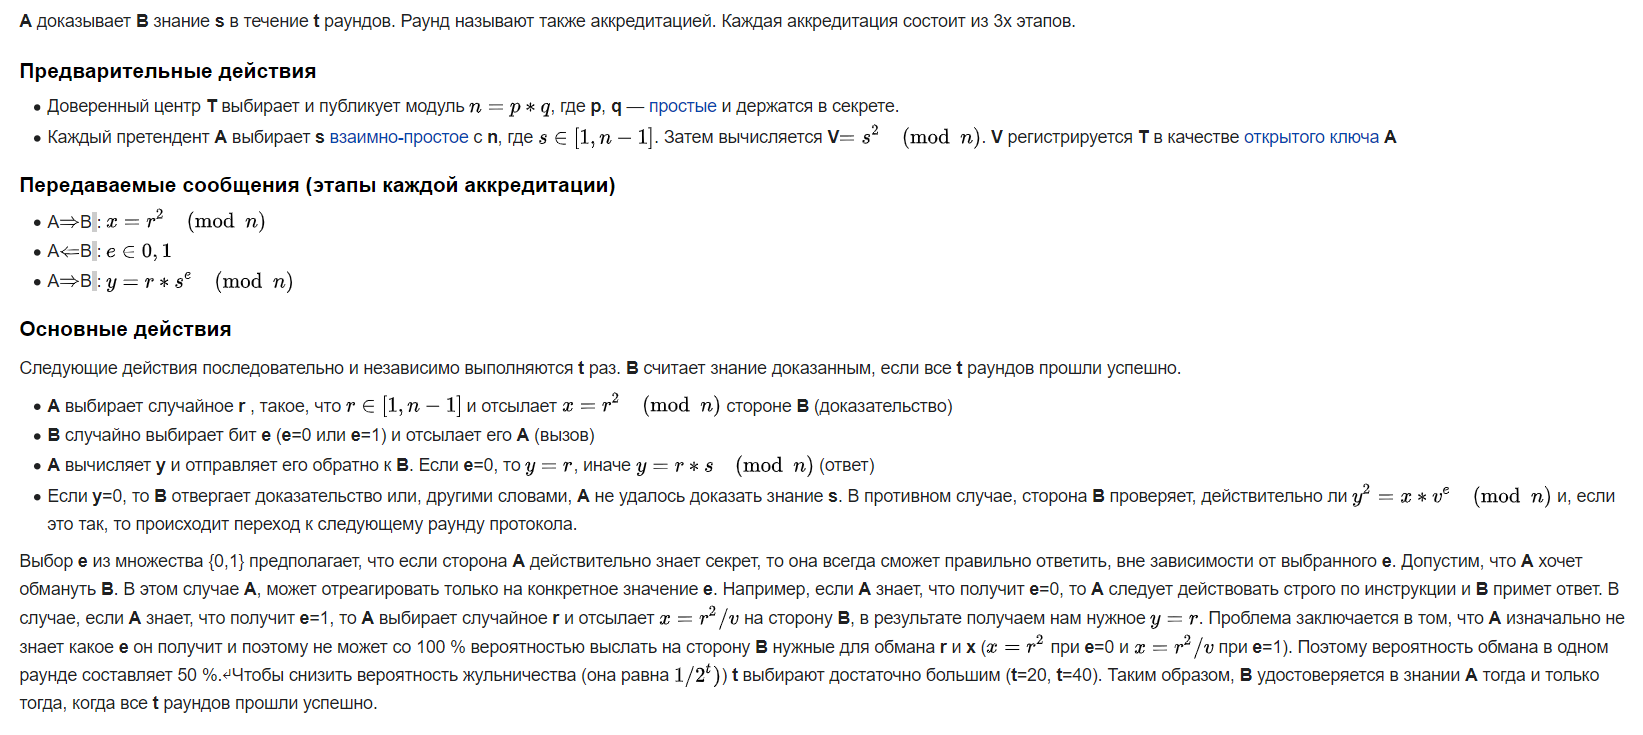

In [76]:
from math import gcd as bltin_gcd
from random import randint

def is_prime(a):
    return all(a % i for i in range(2, a))

def coprime2(a, b):
    return bltin_gcd(a, b) == 1

### Предварительные действия

In [88]:
p = 5477777
q = 2300017
t = 5

class Certification_Authority_1():
    def __init__(self, p, q):
        """
        Step 1: definition of p,q,N
        """
        if is_prime(p) and is_prime(q):
            self._p = p
            self._q = q
            self.N = p*q
        print("-- ДЦ публикует N:", self.N)
        
CA = Certification_Authority_1(p,q)

print("-- A выбирает секрет: ", end="")
while True:
    s = randint(0,CA.N-1)
    if coprime2(s,CA.N):
        break
print(s)

V = pow(s,2,CA.N)
print("-- ДЦ регистрирует открытый ключ V:", V)

-- ДЦ публикует N: 12598980222209
-- A выбирает секрет: 10651700889739
-- ДЦ регистрирует открытый ключ V: 1255110895653


### Основные действия

In [90]:
for _ in range(t):
    # 1
    r = randint(0,CA.N-1)
    print("-- A выбирает случайное r: ", r)
    x = pow(r,2,CA.N)
    print("-- A отправляет B x: ", r)

    # 2
    e = randint(0,1)
    print("-- B отправляет A e:", e)

    # 3
    y = (r * pow(s,e))%CA.N
    print("-- B вычисляет y: ", y)
    
    # 4
    print("-- B проверяет y^2 == x*V^e mod N")
    print(pow(y,2)%CA.N == (x*pow(V,e))%CA.N, "\n")

-- A выбирает случайное r:  12420293484065
-- A отправляет B x:  12420293484065
-- B отправляет A e: 0
-- B вычисляет y:  12420293484065
-- B проверяет y^2 == x*V^e mod N
True 

-- A выбирает случайное r:  9454792471677
-- A отправляет B x:  9454792471677
-- B отправляет A e: 1
-- B вычисляет y:  8362349110736
-- B проверяет y^2 == x*V^e mod N
True 

-- A выбирает случайное r:  8700180005883
-- A отправляет B x:  8700180005883
-- B отправляет A e: 1
-- B вычисляет y:  10727806935214
-- B проверяет y^2 == x*V^e mod N
True 

-- A выбирает случайное r:  8648742295783
-- A отправляет B x:  8648742295783
-- B отправляет A e: 1
-- B вычисляет y:  11838603440959
-- B проверяет y^2 == x*V^e mod N
True 

-- A выбирает случайное r:  10092066703804
-- A отправляет B x:  10092066703804
-- B отправляет A e: 0
-- B вычисляет y:  10092066703804
-- B проверяет y^2 == x*V^e mod N
True 



## Протокол аутентификации Гиллу-Кискатра 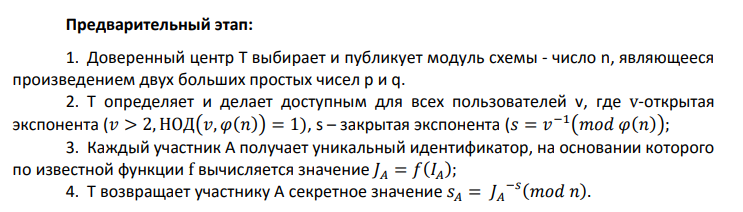

### Предварительный этап

In [91]:
from Crypto.Util.number import bytes_to_long,long_to_bytes,inverse,GCD # обр,Евкл, 
from Crypto.Hash import SHA3_512

p = 5477777
q = 2300017
t = 5

class Certification_Authority_2():
    def __init__(self, p, q):
        """
        Step 1: definition of p,q,N
        """
        self.v = 0
        self._s = 0
        if is_prime(p) and is_prime(q):
            self.p = p
            self.q = q
            self.N = p*q
        print("-- ДЦ публикует N:", self.N)
        self.define_exponents()
        
    def define_exponents(self):
        """
        Step 2
        """
        phi = (self.p-1)*(self.q-1) # функция Эйлера для составного числа из двух простых
        for v in range(2,self.N):
            if GCD(v, phi) == 1: # взаимно простое с phi
                break
        self._s = inverse(v,phi)
        self.v = v
        print("s:" + str(self._s) + "\nv:" + str(v))
        return v
    
    def define_I_a(self):
        I_a = randint(2,self.N-1)
        self.I_a = I_a
        return I_a

    def define_s_a(self):  
        """
        Steps 3,4
        """
        J_a = bytes_to_long(SHA3_512.new(long_to_bytes(self.I_a)).digest())
        s_a = pow(J_a,-self._s,self.N)
        return s_a
    
    

    
CA = Certification_Authority_2(p,q)
N = CA.N
I_a = CA.define_I_a()
print("-- А получает уникальный идентификатор Ia:", I_a)
s_a = CA.define_s_a()

-- ДЦ публикует N: 12598980222209
s:10079177955533
v:5
-- А получает уникальный идентификатор Ia: 1448704092767


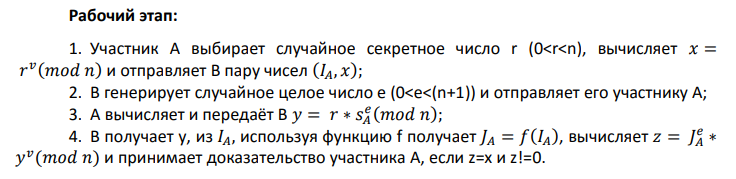

### Рабочий этап

In [92]:
class B():
    def __init__(self, N):
        self.N = N
        self.x = None
        self.I_a = None
        self.N = N
    
    def define_e(self, N):
        e = randint(1,N+1) 
        return e
    
    def send_pare(self, pare):
        """
        Прием пары чисел
        """
        self.I_a = pare[0]
        self.x = pare[1]
        
    def check_y(self, y):
        J_a = bytes_to_long(SHA3_512.new(long_to_bytes(self.I_a)).digest())
        print("---- B вычисляет J_a: \n", J_a)
        z = (pow(J_a,e,self.N)*pow(y,v,self.N))%N
        print("---- B вычисляет z: ", z, "\n и выполняет проверку x==z: ", z == self.x and z != 0)

In [93]:
# 1 Участник А 
r = randint(1,CA.N-1)
x = pow(r,CA.v,N)
pare = (I_a, x)
В_ = B(N)
print("-- A отсылает B пару (I_a,x):", pare)
В_.send_pare(pare)
# 2 B отправляет e
e = В_.define_e(N)
print("-- B генерирует e и отправляет A:",e)
# 3
s_a = CA.define_s_a()
y = r * pow(s_a,e,N)
print("-- A вычисляет y и передает B:", y)
# 4
v = CA.v
print("-- B получает и проверяет y:")
В_.check_y(y)

-- A отсылает B пару (I_a,x): (1448704092767, 675573599411)
-- B генерирует e и отправляет A: 4306698307322
-- A вычисляет y и передает B: 20461811253396075426220164
-- B получает и проверяет y:
---- B вычисляет J_a: 
 292538281856977441361696623787785425186391919894960603683779512705126468914425247608561416819456138577920941813121915736575102620285470224530581900384061
---- B вычисляет z:  675573599411 
 и выполняет проверку x==z:  True


## Протокола Шнорра 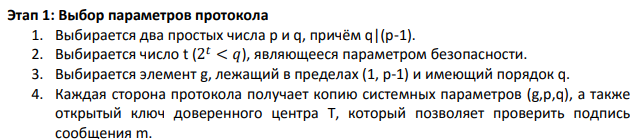 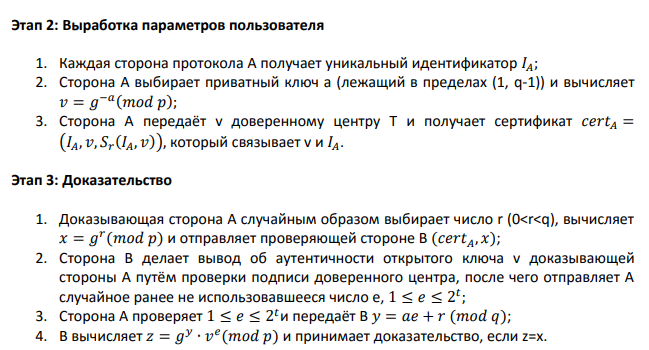

In [111]:
from Crypto.Signature import pkcs1_15
from Crypto.PublicKey import RSA
from Crypto.Util.number import long_to_bytes, inverse

class Certification_Authority_3:
    def __init__(self, p,q,g):
        self.p = p
        self.q = q
        self.g = g
        self._private_key = RSA.generate(4096)
        self.public_key = self._private_key.publickey()
        self.identifiers = []
        self.certs = {}
       
    def request_parameters(self):
        return (self.p, self.q, self.g), self.public_key
    
    
    def generate_id(self):
        return randint(1, self.p)
    
    def request_I_a(self):
        I_a = self.generate_id()
        if I_a in self.identifiers:
            while I_a in self.identifiers:
                I_a = self.generate_id()
        self.identifiers.append(I_a)
        return I_a
    
    
    def request_cert(self, I_a, v):
        if I_a not in self.identifiers:
            return None
        SHA = SHA3_512.new(long_to_bytes(I_a) + long_to_bytes(v))
        sign = PKCS1_PSS.new(self._private_key).sign(SHA)
        self.certs[I_a] = (I_a, v, sign)
        return (I_a, v, sign)

### Выбор параметров протокола

In [112]:
p = 5477777
q = (p - 1) // 2
t=5
print(is_prime(q))
print("-- Выбраны простые p и q: ", p, q)

for g in range(2, p-1):
    if pow(g,q,N) == 1:
        break
        
print("-- Выбран элемент g порядка q:", g)

CA = Certification_Authority_3(p, q, g)
parameters, public_key = CA.request_parameters()
print("-- Доверенный центр Т рассылает копии параметров и публичного ключа:\n",parameters,"\n",public_key)

False
-- Выбраны простые p и q:  5477777 2738888
-- Выбран элемент g порядка q: 371734
-- Доверенный центр Т рассылает копии параметров и публичного ключа:
 (5477777, 2738888, 371734) 
 Public RSA key at 0x1D9B0A9D880


### Выработка параметров пользователя

In [113]:
I_a = CA.request_I_a()
print("-- сторона А получила идентификатор I_a:\n",I_a)
a = randint(1, CA.q-1)
print("-- сторона А выбрала приватный ключ a:\n",a)
v = pow(CA.g,-a,CA.p)
print("-- сторона А вычислила v:\n",v)
cert = CA.request_cert(I_a, v)
print("-- сторона А получает от T сертификат:\n",cert)

-- сторона А получила идентификатор I_a:
 876752
-- сторона А выбрала приватный ключ a:
 8905
-- сторона А вычислила v:
 1847423
-- сторона А получает от T сертификат:
 (876752, 1847423, b'2\xd7_\xe6\xe6\xb8\x96\xb4w\x10\xc9H\xa0\xc0\x9d+\x9f\x7f\xd8\xb0Q\xcf=\x99z\x1fl\x92\xb1%k\x81\x8d1e~e\x9e\xe2\xa4\x8bk\xa3\x93\xb8A\x84)\xd1a\xb4Nw\xeclb\xf6\xc4.\xcb\xb1<\xeaDZ\x90\xe8y\xd6l}\xbdZf}\x0c\x03\xa7t3E%\xac\x19b\xea\t(W\x0f1~\x93V\x943r\xa0\x9e+\xa0\xd1\xc6\xa2\xb5\x04\x054w\xb0R\xae8I\x82\xb1\xed\xb6\xd1eJ3\x9f\x9d\xd9g\x03\x97\xbd\xd1]X\x86\x10\x16N \r\x1bwJ\xde\xc3\xe4\xe1\x1d\xb4q\xc3\xb5;\xf2\xc2\x00\xa2\xe0\tNY\xf8\x84\x95\xf4\xe4r\x89\x9ah\x161 \x11\\\xd4:\x9d\x87%"\xc6\x9e\xa7k \xad(I\xef\xefpUTWun1!\xb9\x94\xe3,Z\xb6r\xa5\xdc\xe0% \xdfH]\xd2\xe8ztz\x92\x0b\x1f\xe6(@\xa6\xc4\x10\xe4\xb6\x02\xf8\x8a\x0b\x171\xab\xa4\x83\xdeO\xea\xe5\ro(\xab\x0e\xb5\x93\x81\xba\xc3\xaf|\x16\x97\xb4\xc5\xe7\xcc\xa2\x96=\x91\x8d\xa2Q\t\x96\xbdS\x12\xb7\xb8mI\xc4\xa6\xc3hC\x82\xcb\x9c\x8f%\x95Y?\xd1

### Доказательство

In [114]:
r = randint(1, CA.q-1)
print("-- сторона А выбрала число r:",r)
x = pow(CA.g,r,CA.p)
print("-- сторона А вычислила x: ",x,", сторона А отправляет стороне B (cert_A,x)")

SHA = SHA3_512.new(long_to_bytes(cert[0]) + long_to_bytes(cert[1]))
print("-- сторона B проверяет подпись доверенного центра:", end=" ")
if PKCS1_PSS.new(public_key).verify(SHA, cert[2]):
    print(True)
    e = randint(1,pow(2,t))
    print("-- сторона B отправляет A случайное e: ", e)
else: 
    print(False)

-- сторона А выбрала число r: 530929
-- сторона А вычислила x:  4958722 , сторона А отправляет стороне B (cert_A,x)
-- сторона B проверяет подпись доверенного центра: True
-- сторона B отправляет A случайное e:  24


In [115]:
if e in range(1, 2**t):
    y = (a*e + r)%CA.q
    print("-- сторона A проверяет e и отправляет y: ", y)
    
z = (pow(CA.g, y, CA.p)*pow(v, e, CA.p))%CA.p
print(z == x)

-- сторона A проверяет e и отправляет y:  744649
True
